In [2]:
import os
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import torch
from dysts.metrics import compute_metrics
from sklearn.decomposition import PCA
from tqdm import tqdm

from panda.chronos.pipeline import ChronosPipeline
from panda.patchtst.pipeline import PatchTSTPipeline
from panda.utils.plot_utils import apply_custom_style

apply_custom_style("../config/plotting.yaml")

/stor/home/jl82436/panda/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device_rank = 3
device = torch.device(f"cuda:{device_rank}" if torch.cuda.is_available() else "cpu")

In [4]:
WORK = os.environ.get("WORK", "")
base_dir = f"{WORK}/physics-datasets"
re = 450
fpath = f"{base_dir}/von_karman_street/vortex_street_velocities_Re_{re}_4800timepoints.npz"

In [5]:
figs_save_dir = "../figures/vonkarman"
os.makedirs(figs_save_dir, exist_ok=True)

In [6]:
vfield = np.load(fpath, allow_pickle=True)
vort_field = np.diff(vfield, axis=1)[..., :-1, 1] + np.diff(vfield, axis=2)[:, :-1, :, 0]
vort_field_flattened = vort_field.reshape(vort_field.shape[0], -1)

## Visualization

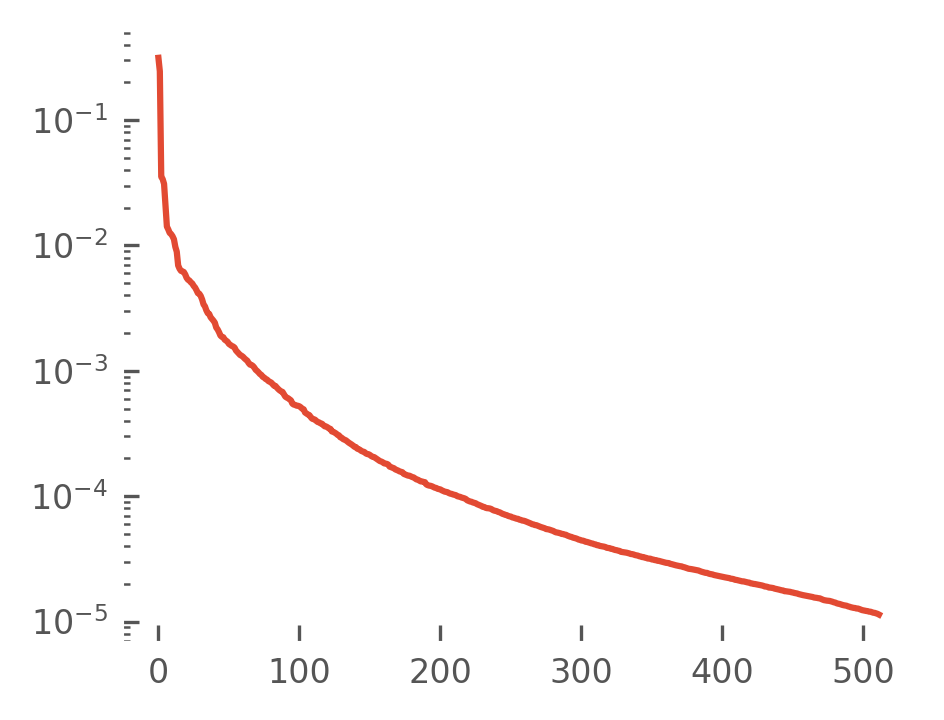

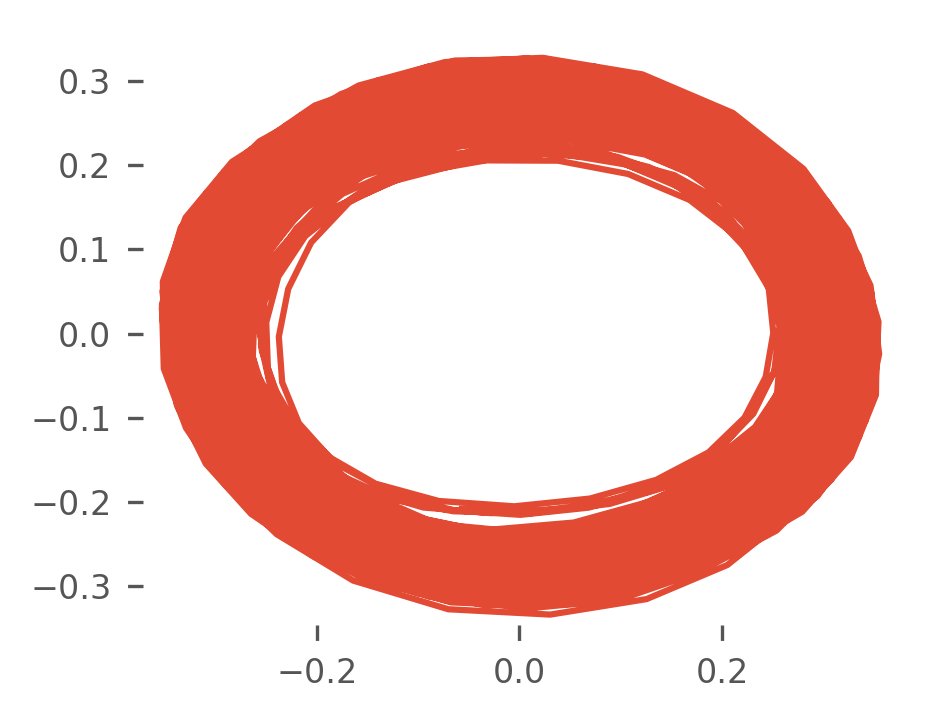

In [7]:
n_components = 512
pca = PCA(n_components=n_components)
pca.fit(vort_field_flattened)
X_ts = pca.transform(vort_field_flattened)  # (T, D)
eigenvectors = pca.components_  # (D, H*W)

## Show low-rank structure
plt.figure()
plt.plot(np.arange(n_components), pca.explained_variance_ratio_)
plt.semilogy()

## Plot trajectory
plt.figure()
plt.plot(X_ts[:, 0], X_ts[:, 1])

In [8]:
def reconstruct(pca_coeffs: np.ndarray, eigenvectors: np.ndarray, modes: int = -1) -> np.ndarray:
    if modes == -1:
        modes = pca_coeffs.shape[1]
    return pca_coeffs[:, :modes] @ eigenvectors[:modes, :]

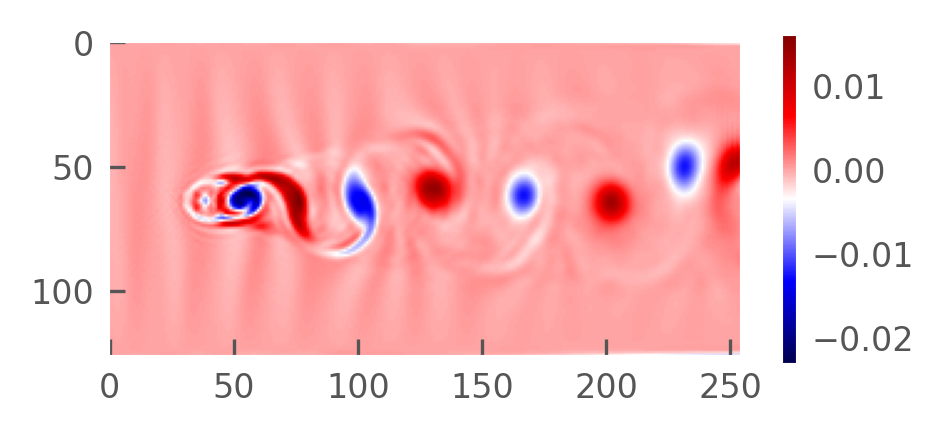

In [9]:
vort_recon = reconstruct(X_ts, eigenvectors)
vort_recon = vort_recon.reshape(vort_field.shape[0], vort_field.shape[1], vort_field.shape[2])
plt.figure()
plt.imshow(vort_recon[100 + 512, :, :].T, cmap="seismic")
plt.colorbar(shrink=0.5);

## Load Model Checkpoints

In [10]:
run_name = "pft_chattn_emb_w_poly-0"
pft_model = PatchTSTPipeline.from_pretrained(
    mode="predict", pretrain_path=f"/stor/work/Gilpin/checkpoints/{run_name}/checkpoint-final", device_map=device
)

In [11]:
chronos_ft = ChronosPipeline.from_pretrained(
    "/stor/work/Gilpin/checkpoints/chronos_t5_mini_ft-0/checkpoint-final",
    device_map=device,
    torch_dtype=torch.float32,
)

In [12]:
chronos_zs = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-mini",
    device_map=device,
    torch_dtype=torch.float32,
)

/stor/home/jl82436/panda/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [13]:
from neuralop.models import FNO


@torch.no_grad()
def fno_rollout(
    context: np.ndarray,
    num_steps: int,
    model: torch.nn.Module,
    lookback: int,
    eigenvectors: np.ndarray,
    shape: tuple[int, int] = (vort_field.shape[1], vort_field.shape[2]),
) -> torch.Tensor:
    ic = torch.tensor(context[-lookback:]).float().to(device).unsqueeze(0)
    traj = [ic]
    state = ic.clone()
    for _ in range(num_steps):
        pred = model(state)
        traj.append(pred)
        state = torch.cat([state[:, :-1, :], pred], dim=1)
    pred = torch.cat(traj, dim=1)[:, lookback:, :].cpu().numpy().squeeze()
    return reconstruct(pred, eigenvectors).reshape(-1, *shape)


lookback = 1
operator = FNO(n_modes=(256,), hidden_channels=256, in_channels=lookback, out_channels=1).to(device)
operator.load_state_dict(
    torch.load(f"{WORK}/checkpoints/VKVS_baselines/best_model_state_dict.pt", map_location=device, weights_only=False)
)
operator.eval()

FNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([256, 256, 129]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(256, 256, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(256, 128, kernel_size=(1,), stride=(1,))
          (1): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(2, 512, kernel_size=(1,), stride=(1,))
      (1): Conv1d(512, 256, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(256, 512, kernel_size=(1,), stride=(1,))
      (1): Conv1d(512, 1, k

In [14]:
import deepxde as dde


@torch.no_grad()
def deeponet_rollout(
    context: np.ndarray,
    num_steps: int,
    model: torch.nn.Module,
    xs: np.ndarray,
    eigenvectors: np.ndarray,
    shape: tuple[int, int] = (vort_field.shape[1], vort_field.shape[2]),
):
    ic = torch.tensor(context[-1]).float().to(device).unsqueeze(0)
    traj = [ic]
    state = ic.clone()
    for _ in range(num_steps):
        state = model((state, xs))
        traj.append(state)
    pred = torch.cat(traj, dim=0)[1:].cpu().numpy().squeeze()
    return reconstruct(pred, eigenvectors).reshape(-1, *shape)


xs = np.linspace(0, 1, n_components, endpoint=False).astype(np.float32).reshape(-1, 1)  # (N,1)
xs = torch.from_numpy(xs).float().to(device)

net = dde.nn.DeepONetCartesianProd(
    [n_components, 128, 128, 128],
    [1, 128, 128, 128],
    "gelu",
    "Glorot normal",
).to(device)
state_dict = torch.load(f"{WORK}/checkpoints/VKVS_baselines/deeponet.pt", map_location=device, weights_only=False)[
    "model_state_dict"
]
net.load_state_dict(state_dict)
net.eval()
torch.set_default_device("cpu")

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


## Plotting and Forecasting

In [15]:
@torch.no_grad()
def forecast(
    model: torch.nn.Module,
    context: np.ndarray,
    prediction_length: int,
    eigenvectors: np.ndarray,
    batch_size: int | None = None,
    shape: tuple[int, int] = vort_field.shape[1:3],
    num_modes: int | None = None,
    transpose: bool = False,
    **kwargs,
) -> np.ndarray:
    torch.cuda.empty_cache()
    context_tensor = torch.from_numpy(context).float()

    if transpose:
        context_tensor = context_tensor.T

    if batch_size is None:
        pred = model.predict(context_tensor, prediction_length, **kwargs)
    else:
        pred = []
        for i in range(0, context_tensor.shape[0], batch_size):
            pred.append(model.predict(context_tensor[i : i + batch_size], prediction_length, **kwargs))
        pred = torch.cat(pred, dim=0)

    pred = pred.squeeze().detach().cpu().numpy()
    if transpose:
        pred = pred.T

    recon = reconstruct(pred, eigenvectors, modes=num_modes)
    recon = recon.reshape(prediction_length, shape[0], shape[1])
    return recon

In [16]:
def plot_predicted_flow(
    prediction: np.ndarray,
    groundtruth: np.ndarray,
    time_indices: list[int],
    shape: tuple[int, int] = (vort_field.shape[1], vort_field.shape[2]),
    save_path: str | None = None,
    cmap_name="seismic",
    base_figsize=(5, 5),
    suptitle: str | None = None,
    suptitle_y: float = 1.0,
):
    vabs = max(np.abs(groundtruth.min()), np.abs(groundtruth.max()))

    aspect_ratio = shape[0] / shape[1]
    fig = plt.figure(
        figsize=(
            base_figsize[0] * (len(time_indices)) / aspect_ratio,
            base_figsize[1] * aspect_ratio,
        )
    )
    gs = fig.add_gridspec(
        2,
        len(time_indices),
        width_ratios=[1] * (len(time_indices)),
        height_ratios=[1, 1],
        wspace=0,
        hspace=0,
    )
    axes = np.array([[fig.add_subplot(gs[i, j]) for j in range(len(time_indices))] for i in range(2)])
    for i, index in enumerate(time_indices):
        groundtruth_slice = groundtruth[index, :, :]
        recon_slice = prediction[index, :, :]

        gax = axes[0, i].imshow(
            groundtruth_slice,
            vmin=-vabs,
            vmax=vabs,
            cmap=cmap_name,
        )

        axes[0, i].spines["top"].set_visible(True)
        axes[0, i].spines["right"].set_visible(True)
        axes[0, i].spines["bottom"].set_visible(True)
        axes[0, i].spines["left"].set_visible(True)
        axes[0, i].spines["top"].set_color("black")
        axes[0, i].spines["right"].set_color("black")
        axes[0, i].spines["bottom"].set_color("black")
        axes[0, i].spines["left"].set_color("black")

        axes[0, i].set_title(
            # f"t={context_length}" + (f" + {index}" if index > 0 else ""),
            "t = context" + (f" + {index + 1}" if index > 0 else ""),
            fontsize=12,
            fontweight="bold",
        )
        axes[0, i].set_xticks([])
        axes[0, i].set_yticks([])

        rax = axes[1, i].imshow(
            recon_slice,
            vmin=-vabs,
            vmax=vabs,
            cmap=cmap_name,
        )
        axes[1, i].spines["top"].set_visible(True)
        axes[1, i].spines["right"].set_visible(True)
        axes[1, i].spines["bottom"].set_visible(True)
        axes[1, i].spines["left"].set_visible(True)
        axes[1, i].spines["top"].set_color("black")
        axes[1, i].spines["right"].set_color("black")
        axes[1, i].spines["bottom"].set_color("black")
        axes[1, i].spines["left"].set_color("black")

        axes[1, i].set_xticks([])
        axes[1, i].set_yticks([])

        circle = plt.Circle((0.5 * shape[1] + 1, 0.145 * shape[0]), 5, fill=True, color="black")
        axes[0, i].add_patch(circle)
        circle = plt.Circle((0.5 * shape[1] + 1, 0.145 * shape[0]), 5, fill=True, color="black")
        axes[1, i].add_patch(circle)

    axes[0, 0].set_ylabel("Ground Truth", fontweight="bold", fontsize=16)
    axes[1, 0].set_ylabel("Predictions", fontweight="bold", fontsize=16)

    if suptitle is not None:
        plt.suptitle(suptitle, fontweight="bold", fontsize=18, ha="center", y=suptitle_y)

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight")
    else:
        plt.show()

## Forecasts

In [17]:
stride = 1
start = 2048  # ignore transient
context_length = 512
prediction_length = 128
time_indices = [15, 31, 63, 127]

strided_X = X_ts[start::stride]
groundtruth = reconstruct(strided_X[context_length : context_length + prediction_length], eigenvectors).reshape(
    -1, *vort_field.shape[1:]
)

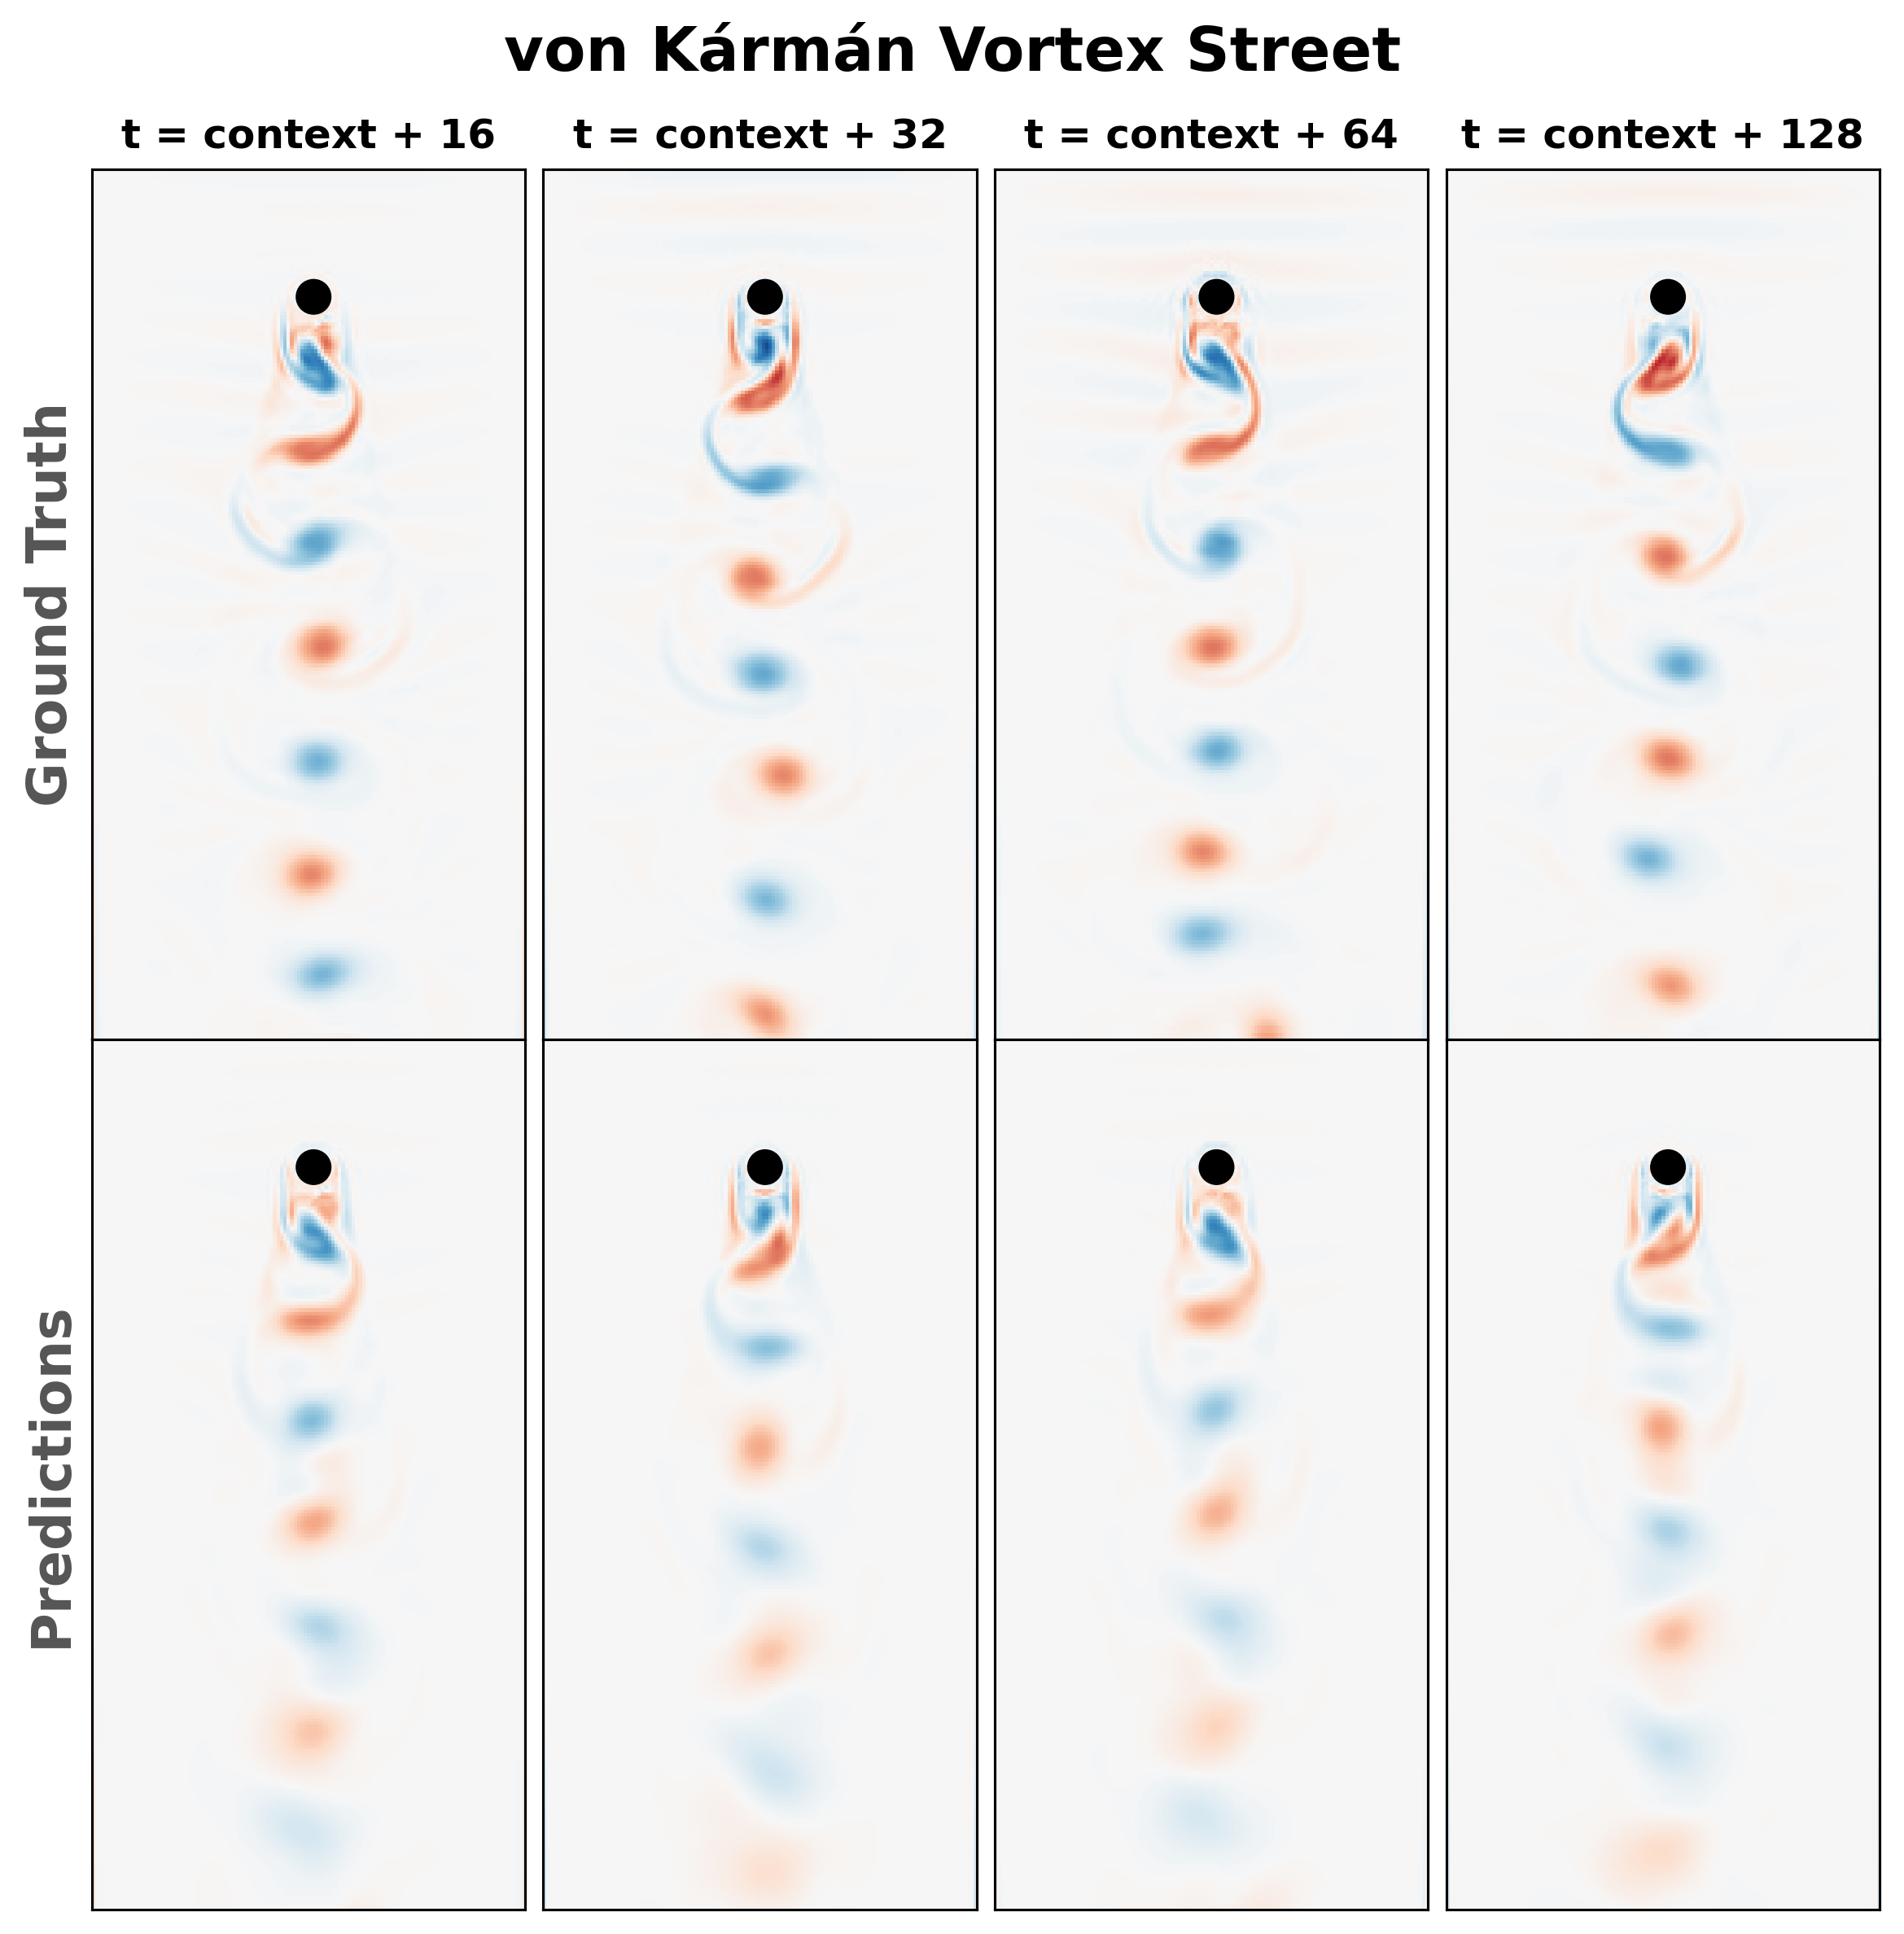

In [18]:
panda_prediction = forecast(
    pft_model,
    strided_X[:context_length],
    prediction_length,
    eigenvectors,
    sliding_context=True,
    limit_prediction_length=False,
)
plot_predicted_flow(
    panda_prediction,
    groundtruth,
    time_indices=time_indices,
    cmap_name="RdBu",
    base_figsize=(4, 4),
    save_path=os.path.join(figs_save_dir, "von_karman_our_model.pdf"),
    suptitle="von Kármán Vortex Street",
    suptitle_y=0.98,
)

/stor/home/jl82436/panda/.venv/lib/python3.12/site-packages/torch/utils/_device.py:103: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at /pytorch/aten/src/ATen/native/BucketizationUtils.h:32.)
  return func(*args, **kwargs)


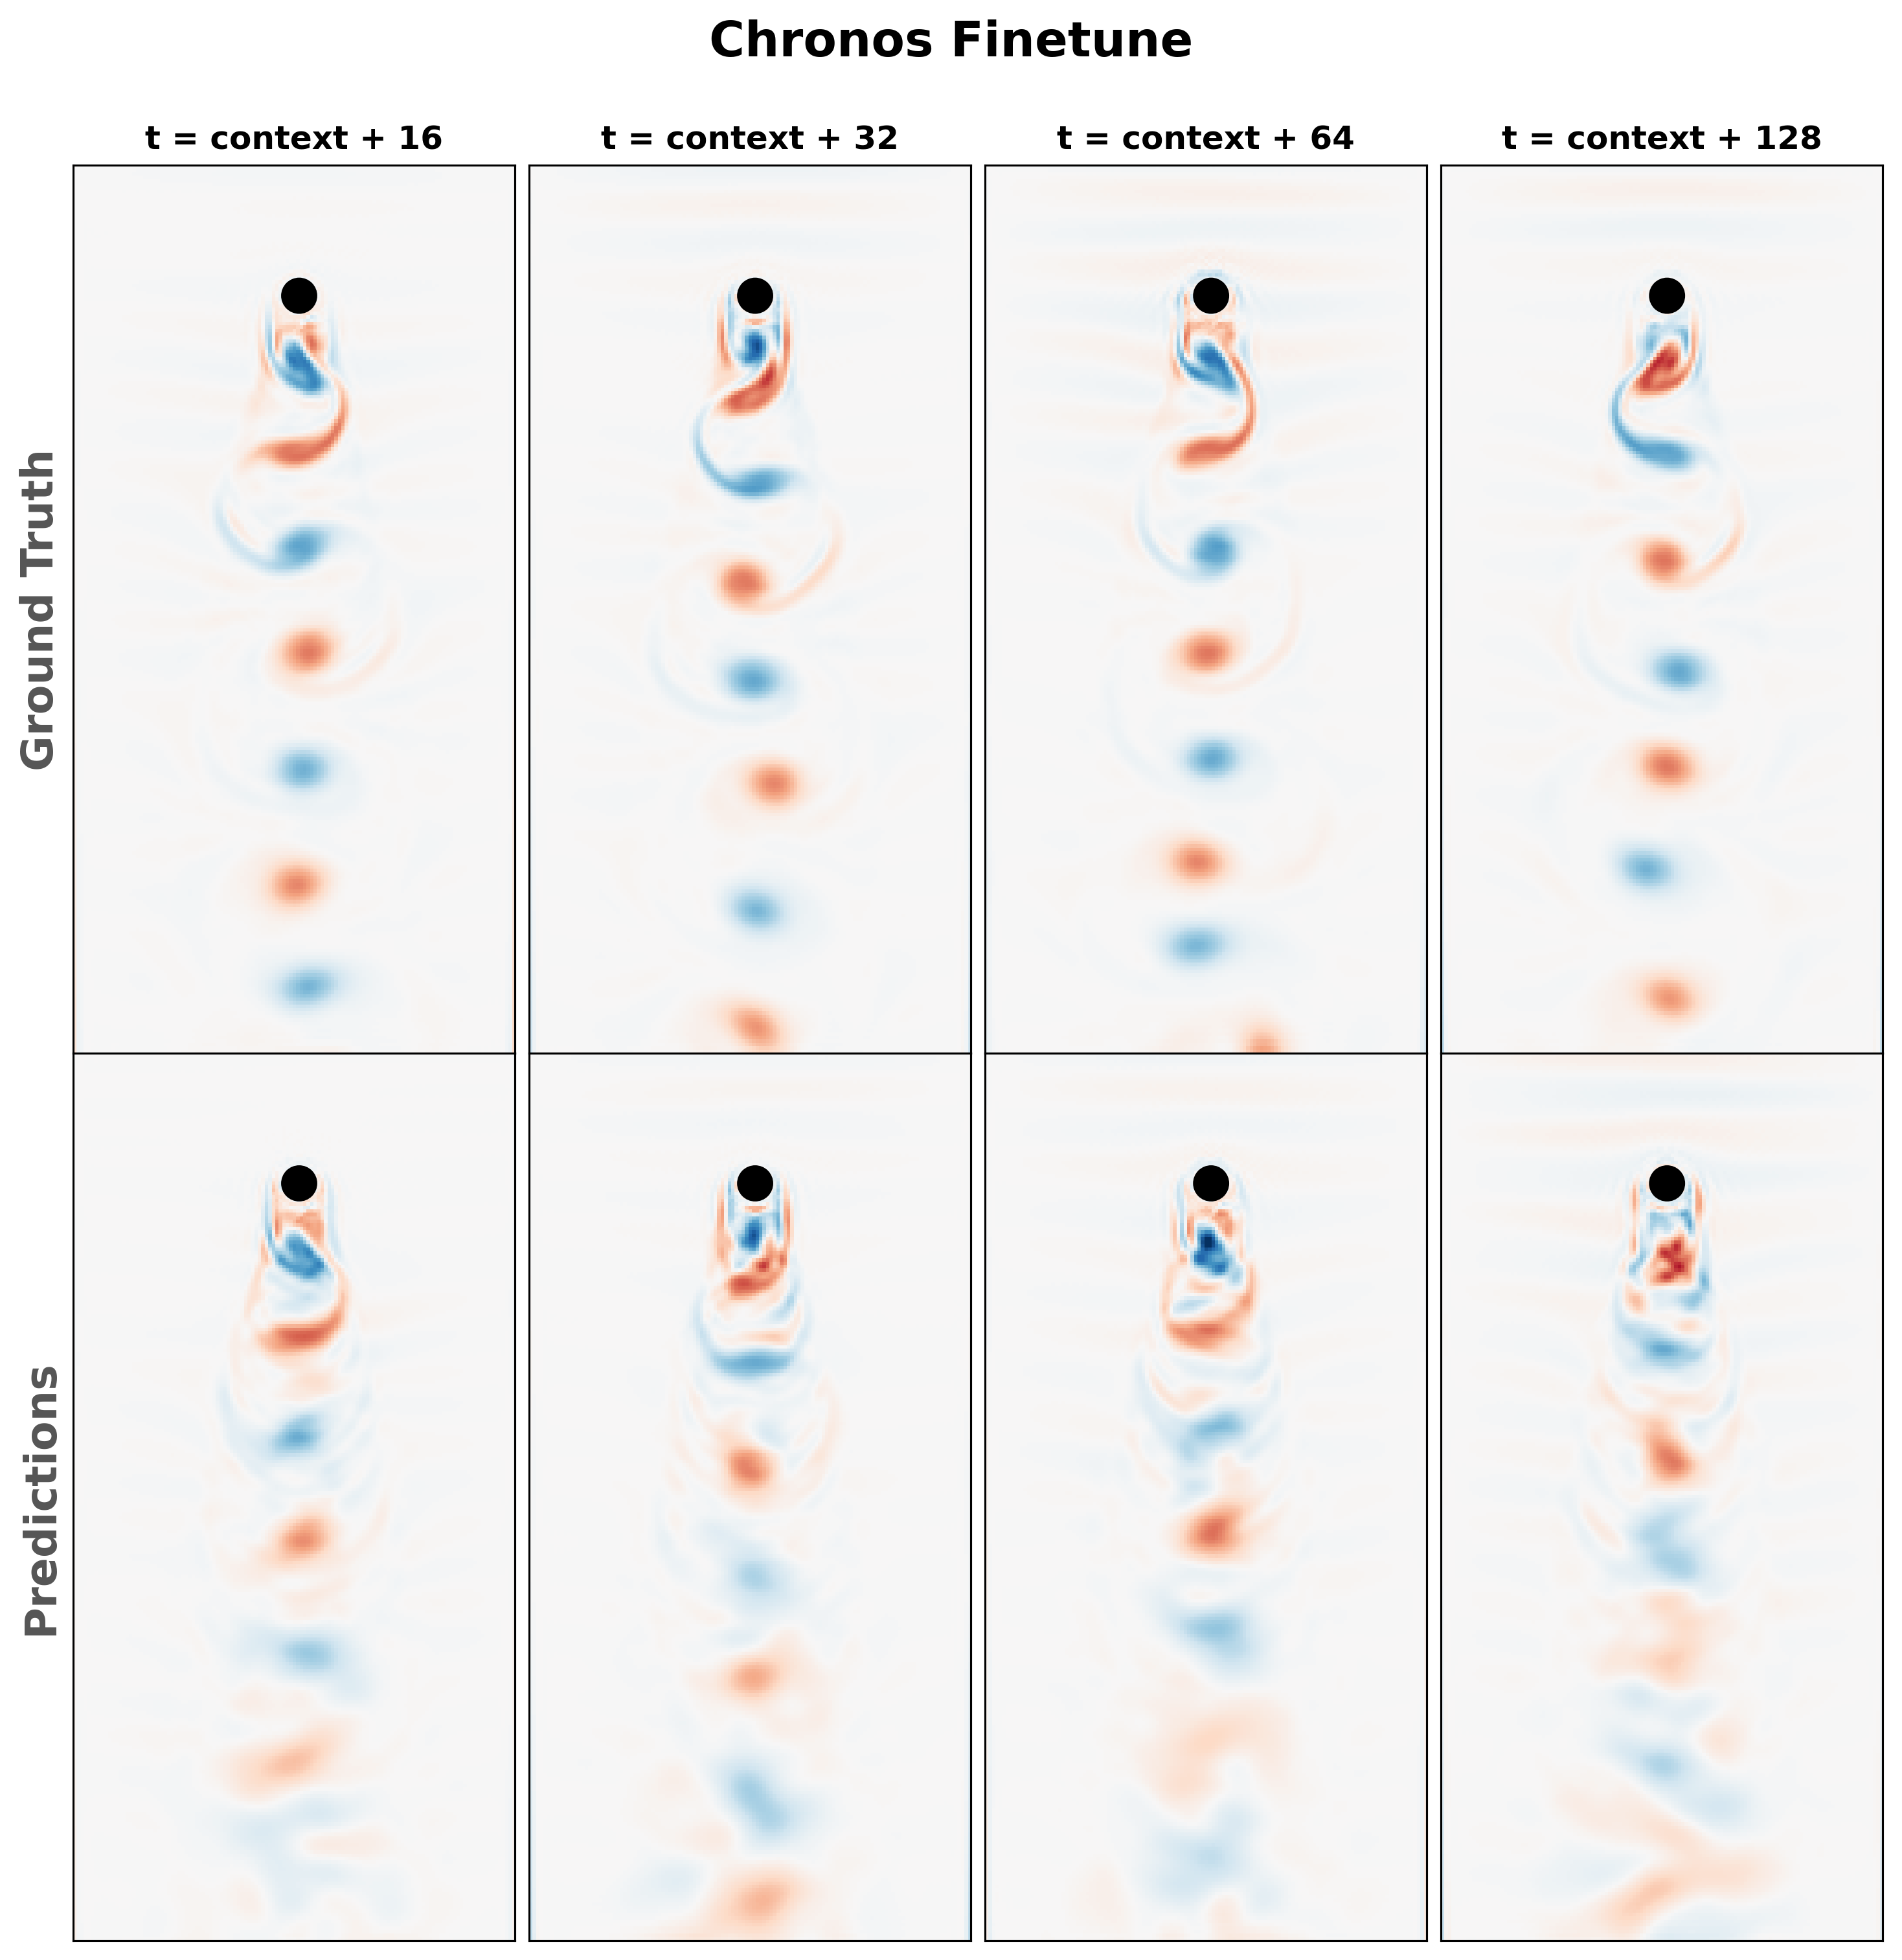

In [19]:
chronos_ft_prediction = forecast(
    chronos_ft,
    strided_X[:context_length],
    prediction_length,
    eigenvectors,
    batch_size=256,
    transpose=True,
    limit_prediction_length=False,
    num_samples=1,
    deterministic=True,
)
plot_predicted_flow(
    chronos_ft_prediction,
    groundtruth,
    time_indices=time_indices,
    cmap_name="RdBu",
    save_path=os.path.join(figs_save_dir, "von_karman_chronos_ft.pdf"),
    suptitle="Chronos Finetune",
)

/stor/home/jl82436/panda/panda/chronos/pipeline.py:162: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


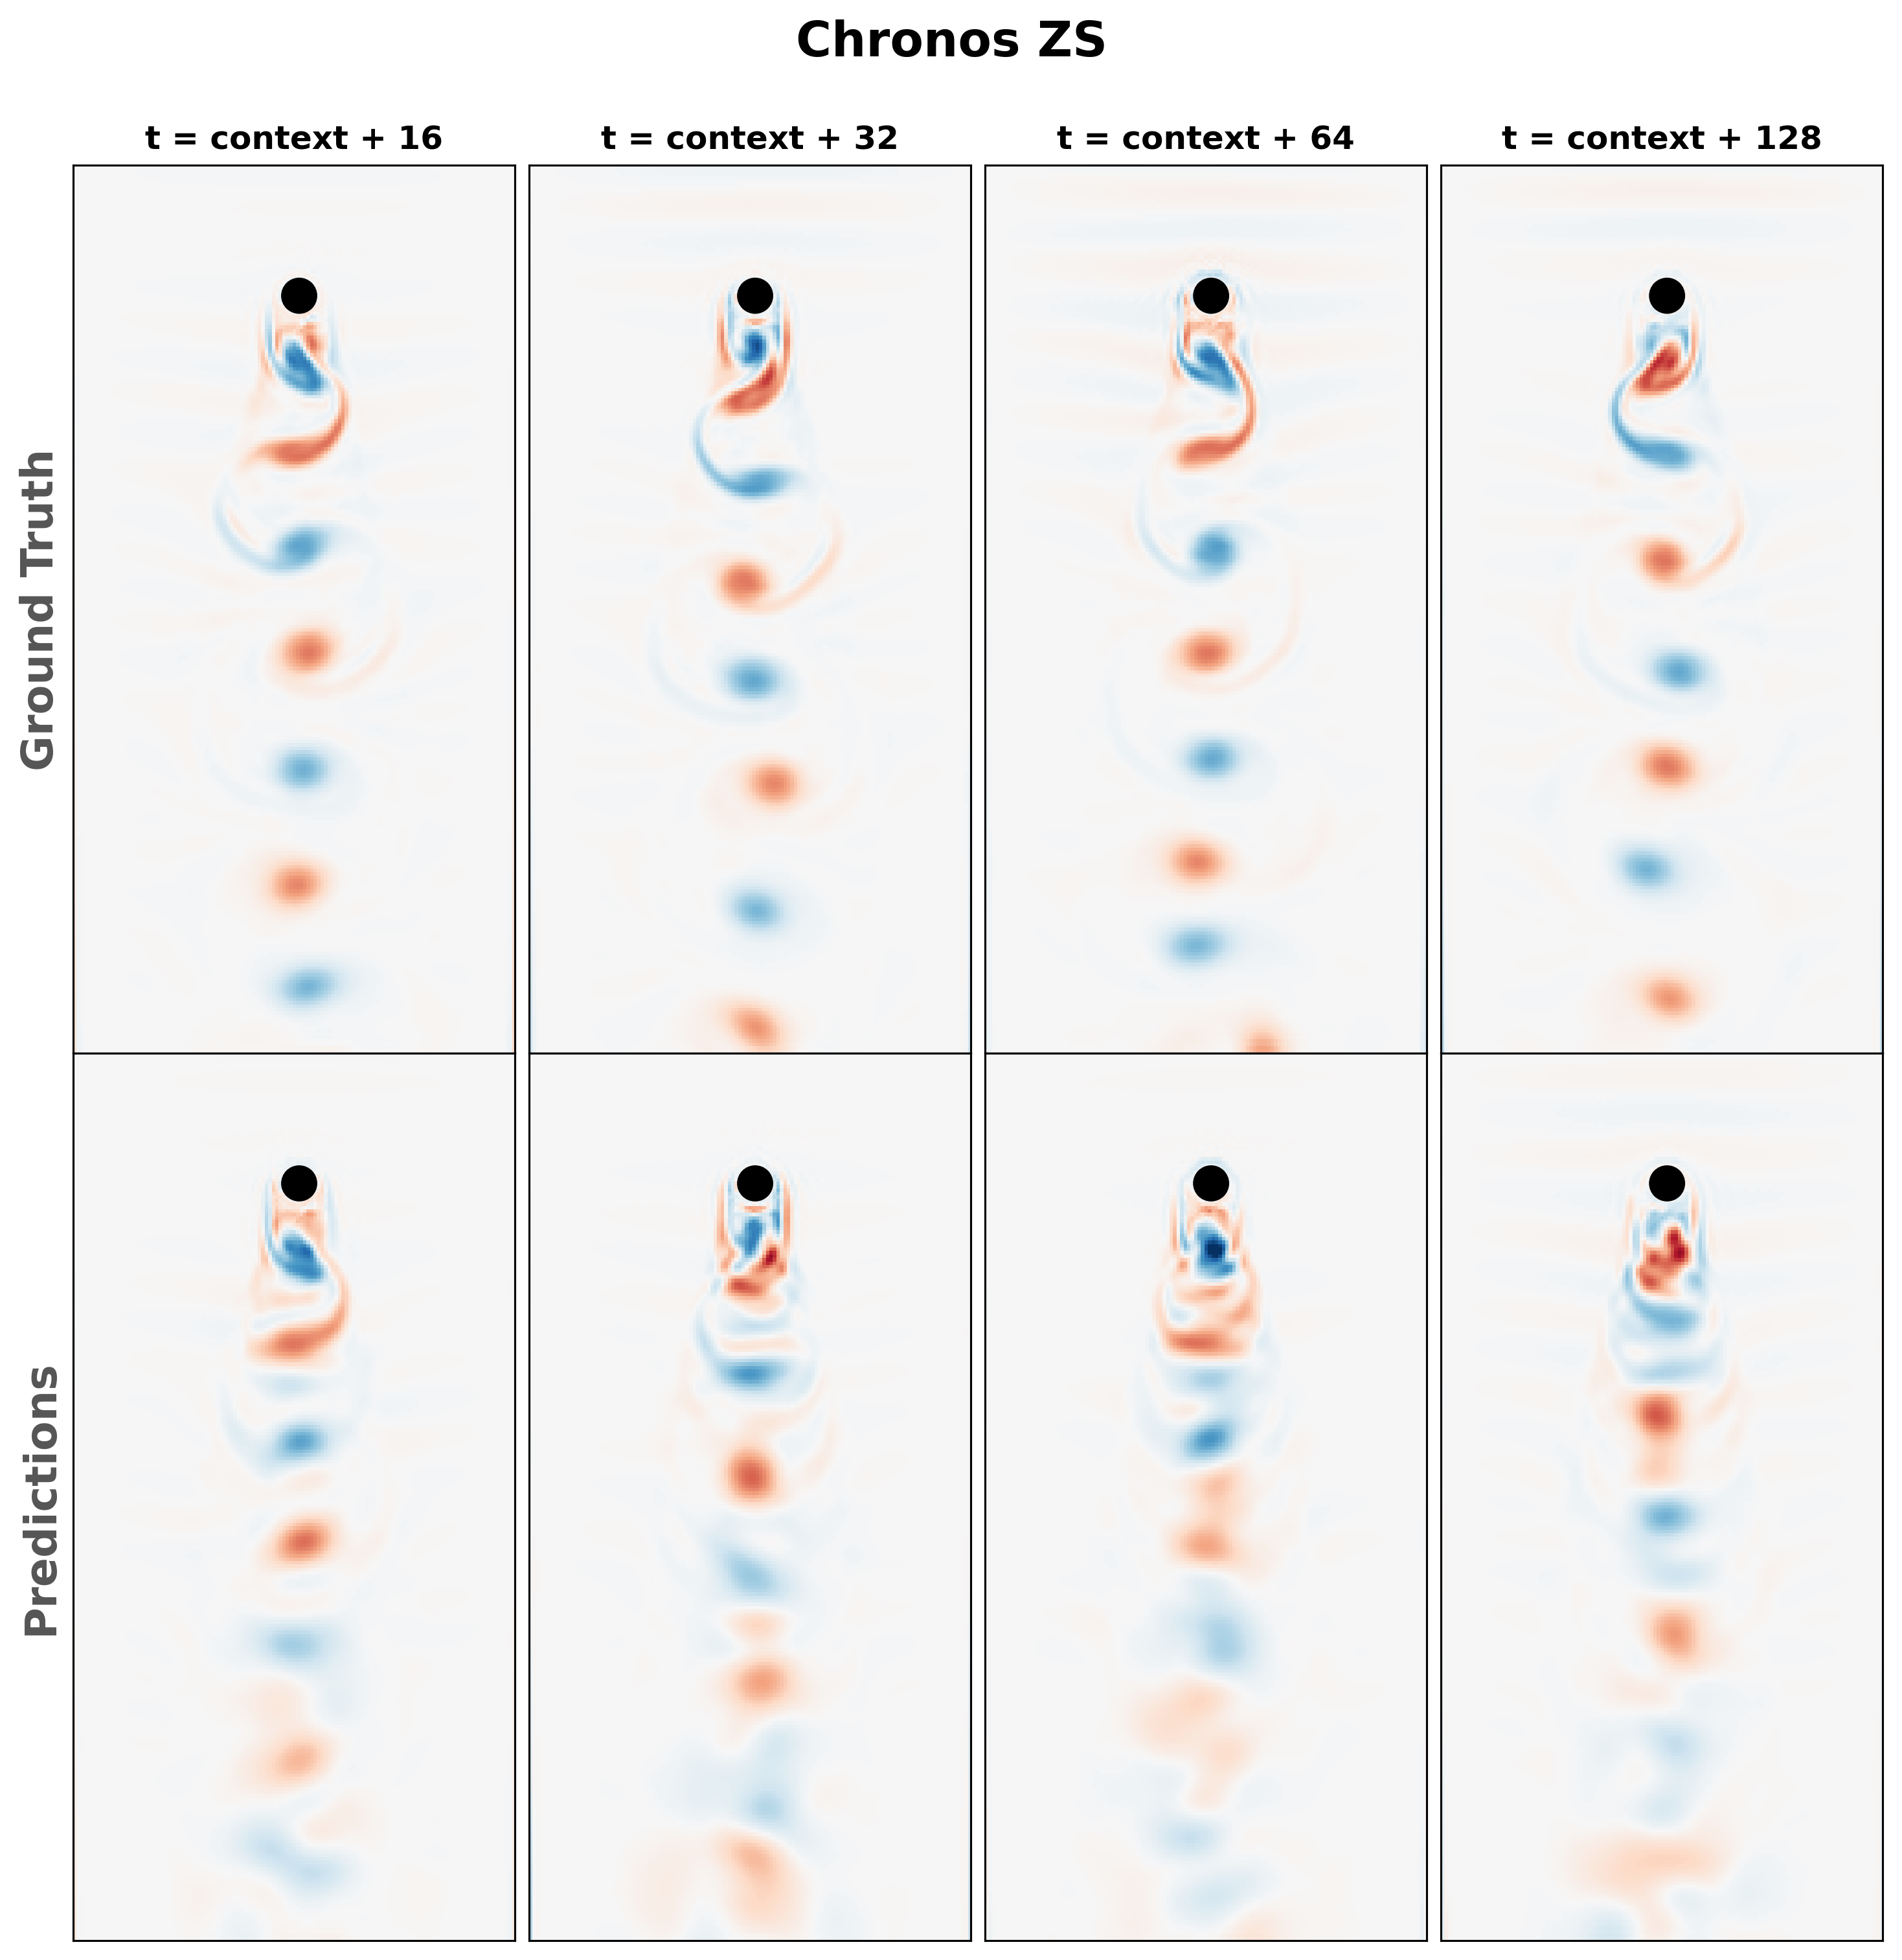

In [20]:
chronos_zs_prediction = forecast(
    chronos_zs,
    strided_X[:context_length],
    prediction_length,
    eigenvectors,
    batch_size=256,
    transpose=True,
    limit_prediction_length=False,
    num_samples=1,
    deterministic=True,
)
plot_predicted_flow(
    chronos_zs_prediction,
    groundtruth,
    time_indices=time_indices,
    cmap_name="RdBu",
    save_path=os.path.join(figs_save_dir, "von_karman_chronos_zs.pdf"),
    suptitle="Chronos ZS",
)

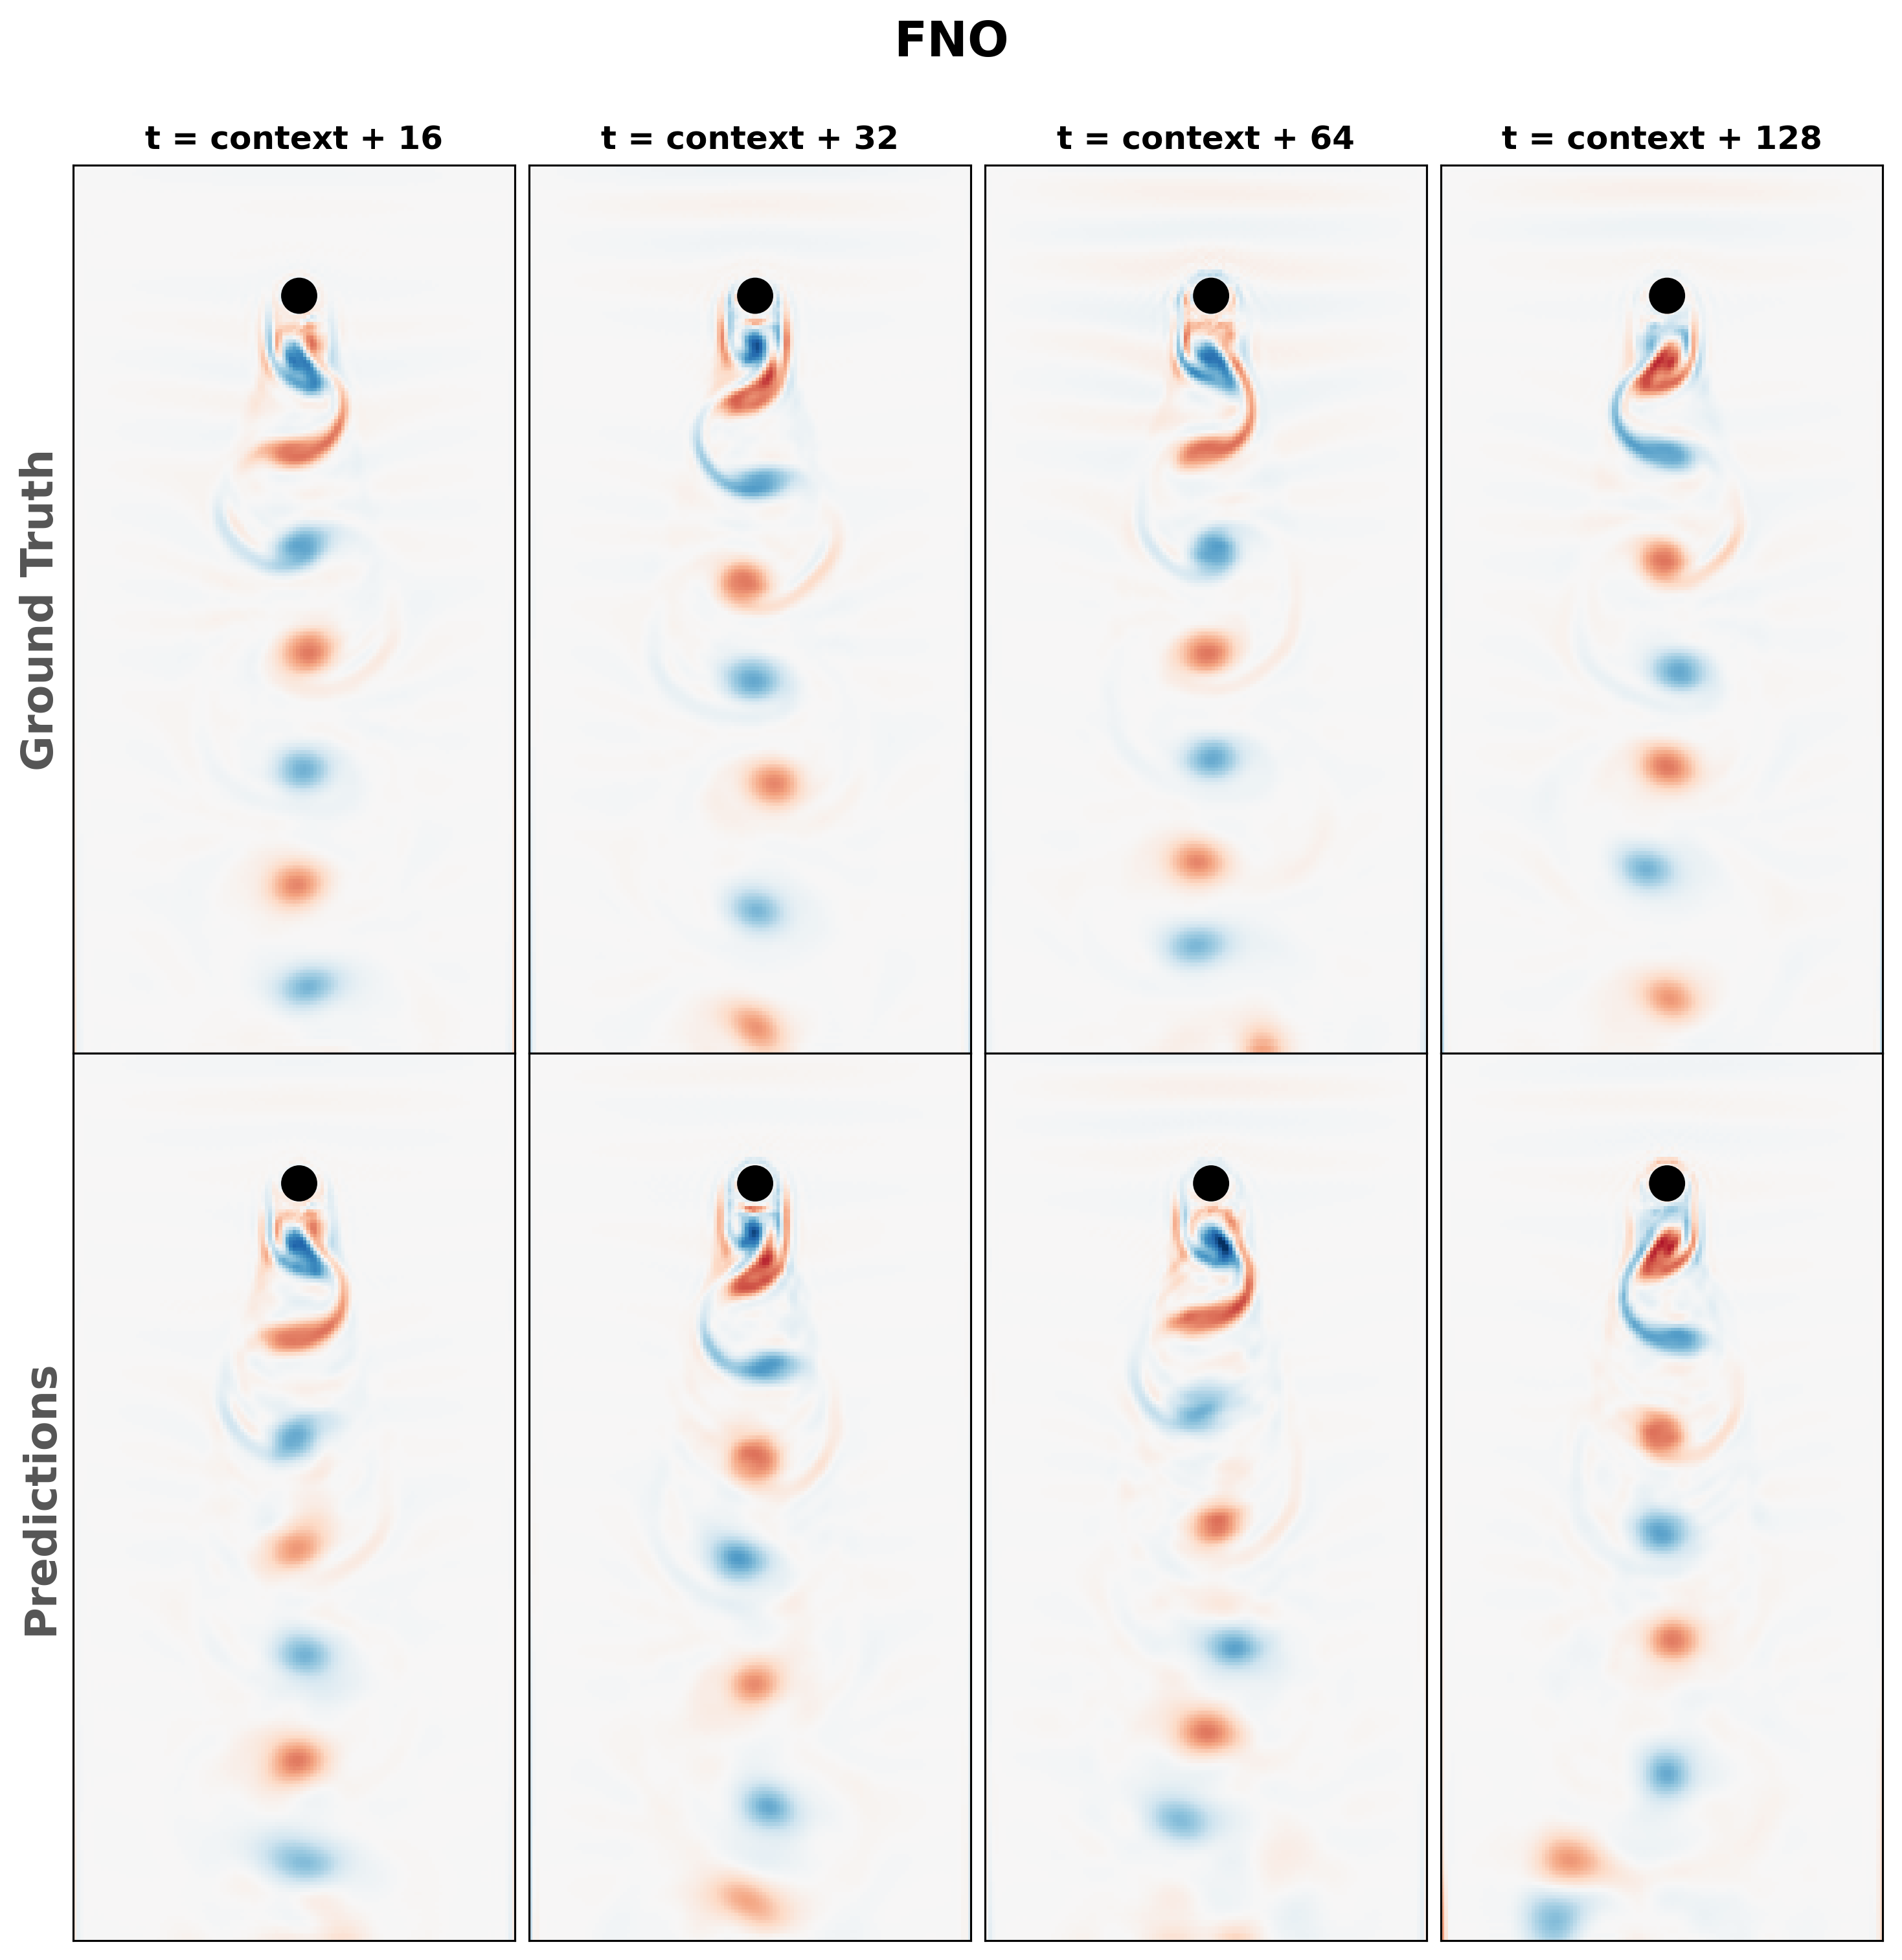

In [21]:
fno_prediction = fno_rollout(strided_X[:context_length], prediction_length, operator, lookback, eigenvectors)
plot_predicted_flow(
    fno_prediction,
    groundtruth,
    time_indices=time_indices,
    cmap_name="RdBu",
    save_path=os.path.join(figs_save_dir, "von_karman_fno.pdf"),
    suptitle="FNO",
)

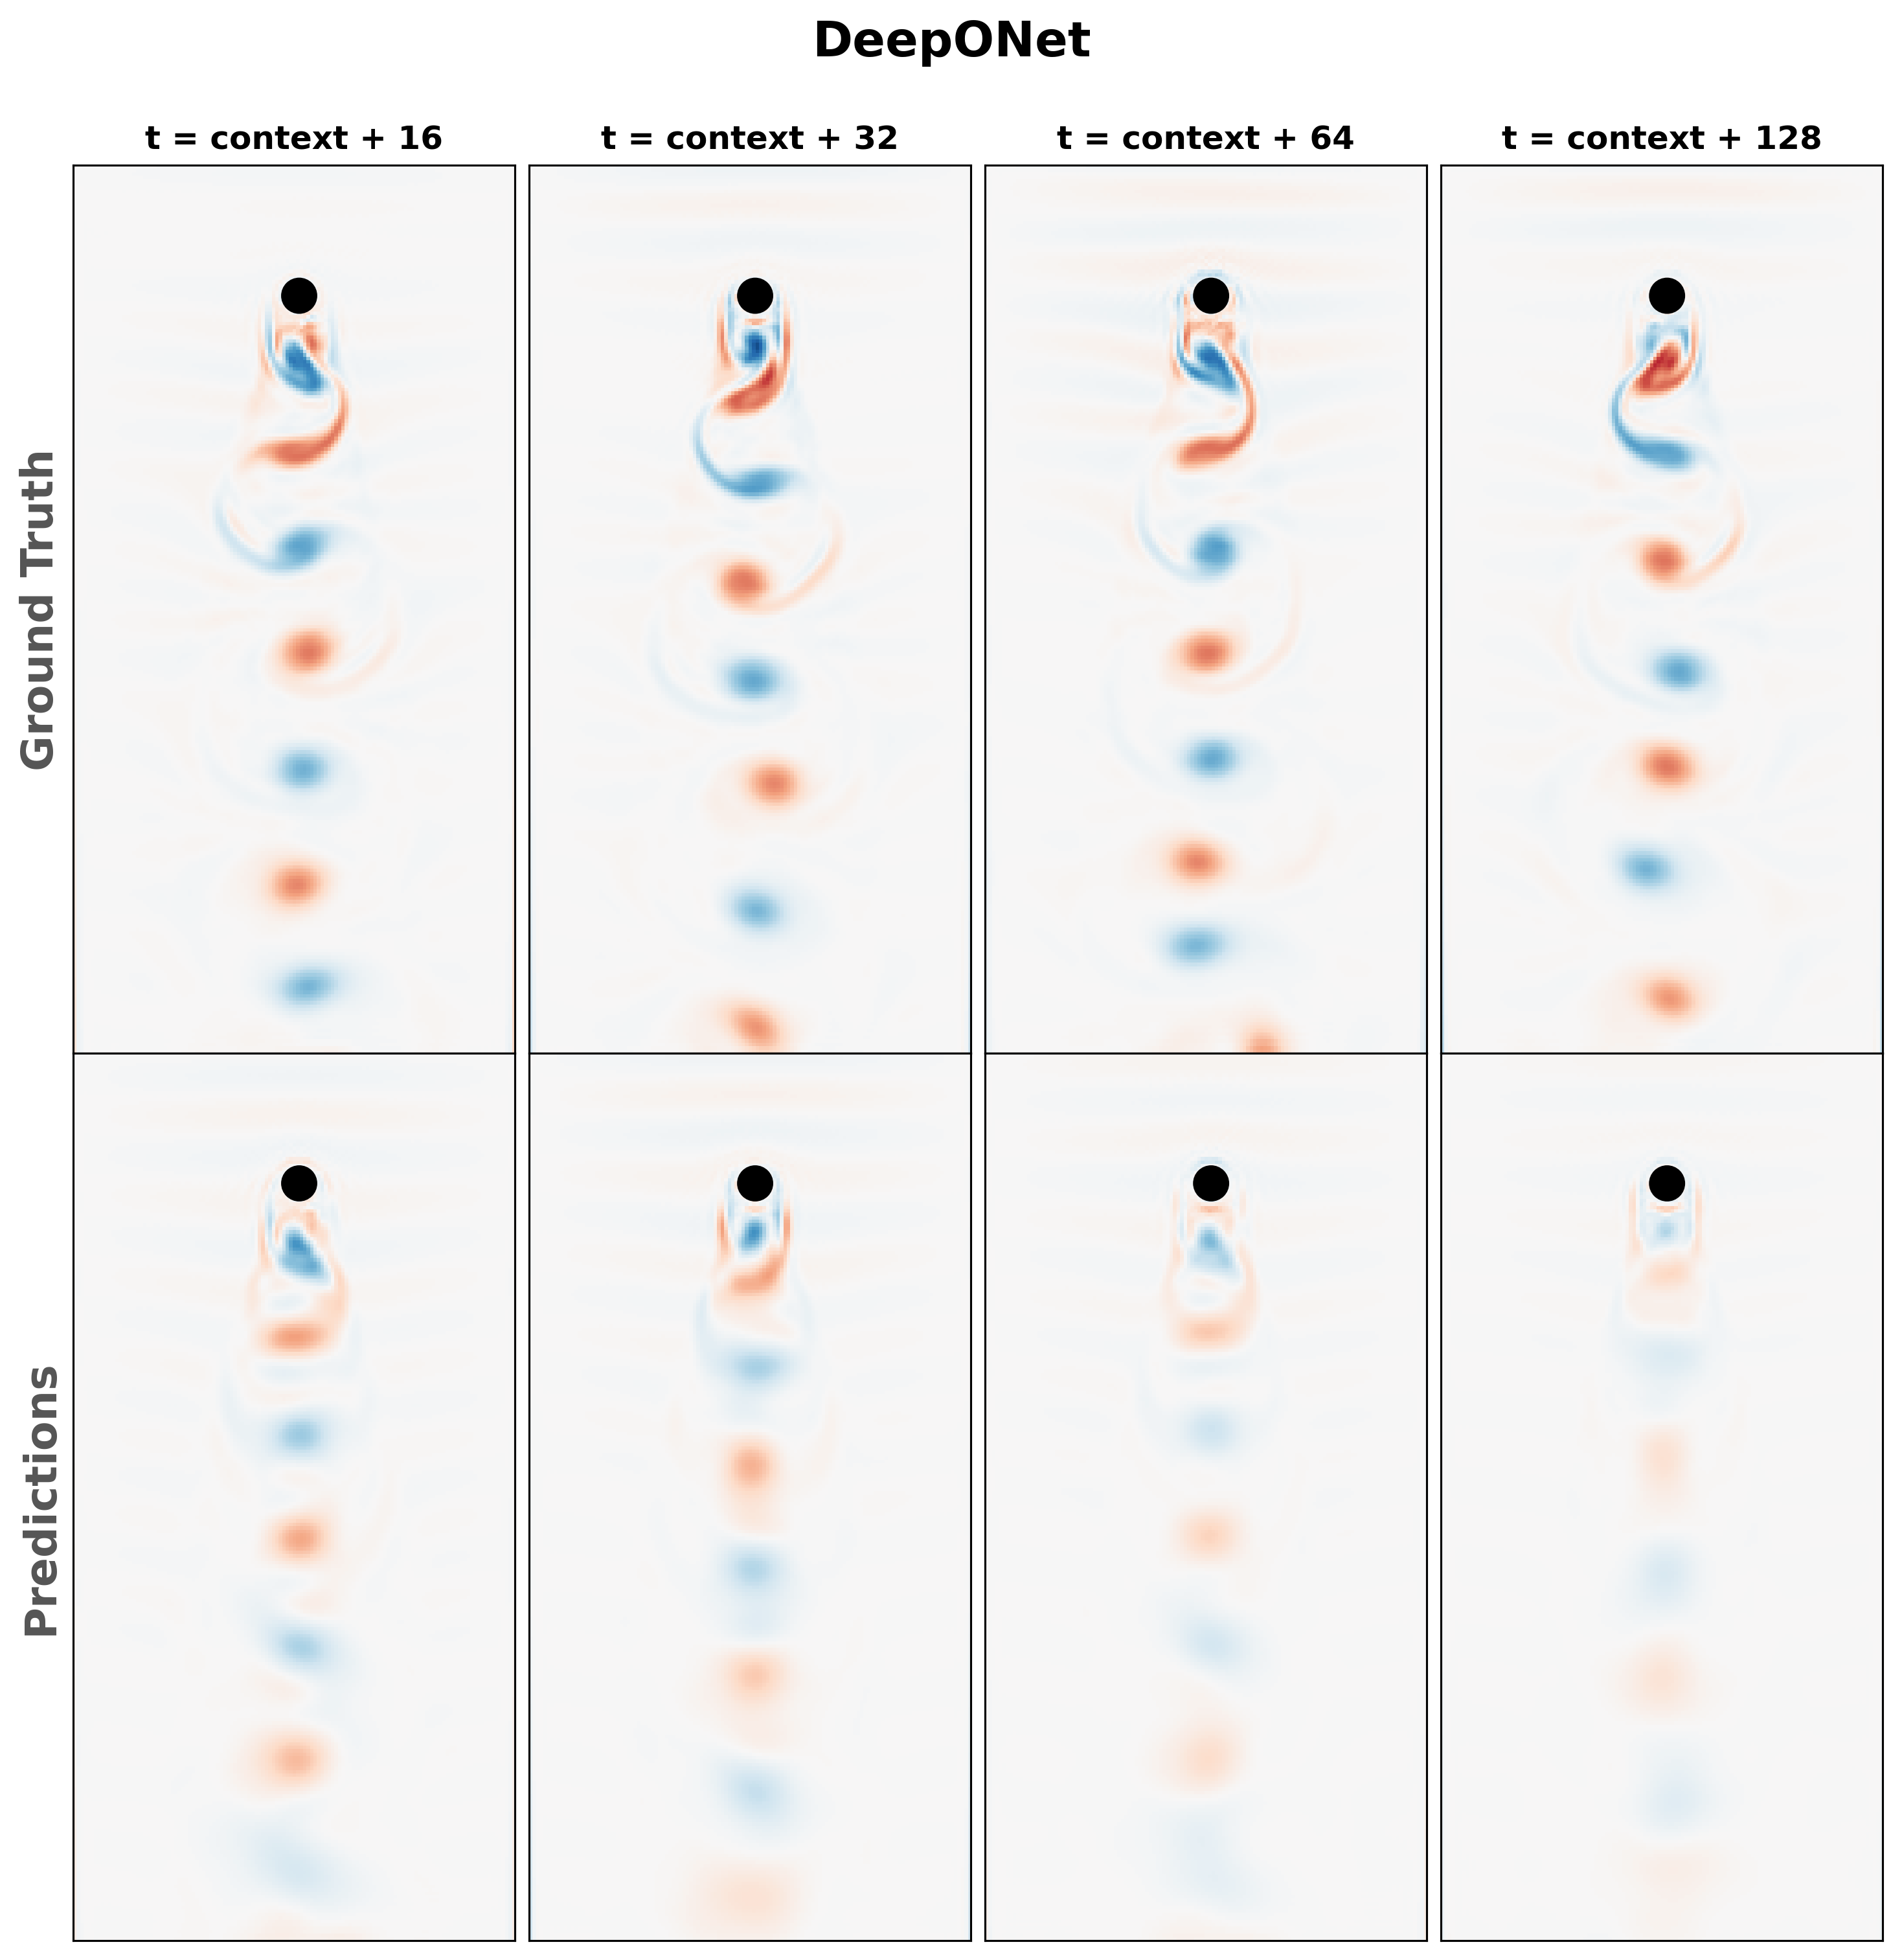

In [22]:
don_prediction = deeponet_rollout(strided_X[:context_length], prediction_length, net, xs, eigenvectors)
plot_predicted_flow(
    don_prediction,
    groundtruth,
    time_indices=time_indices,
    cmap_name="RdBu",
    save_path=os.path.join(figs_save_dir, "von_karman_don.pdf"),
    suptitle="DeepONet",
)

## Longer Rollout Metrics

In [23]:
def compute_rollout_metrics(
    prediction: np.ndarray,
    groundtruth: np.ndarray,
    time_interval: int = 64,
):
    prediction_length = prediction.shape[0]
    metrics = {}
    rollout_time_intervals = np.arange(time_interval, prediction_length + time_interval, time_interval)
    for t in rollout_time_intervals:
        metrics[t] = compute_metrics(prediction[0:t], groundtruth[0:t], include=["mae", "mse", "smape"])

    return metrics

In [24]:
n_runs = 10
start_times = np.arange(512, 3072, (3072 - 512) // n_runs)
start_times = start_times.astype(int)
print(f"{len(start_times)} start_times: {start_times}")

prediction_length = 512
use_chronos_deterministic = True


10 start_times: [ 512  768 1024 1280 1536 1792 2048 2304 2560 2816]


In [25]:
our_model_rollout_metrics = defaultdict(dict)
for start_time in tqdm(start_times, desc="Running rollouts"):
    context_start = start_time + context_length
    end = context_start + prediction_length
    groundtruth = reconstruct(X_ts[context_start:end:stride], eigenvectors).reshape(-1, *vort_field.shape[1:])
    panda_prediction = forecast(
        pft_model,
        X_ts[start_time:context_start:stride],
        prediction_length,
        eigenvectors,
        sliding_context=True,
        limit_prediction_length=False,
    )
    metrics = compute_rollout_metrics(panda_prediction, groundtruth, time_interval=64)
    for t, metric in metrics.items():
        for metric_name, metric_val in metric.items():
            if t not in our_model_rollout_metrics[metric_name]:
                our_model_rollout_metrics[metric_name][t] = []
            our_model_rollout_metrics[metric_name][t].append(metric_val)

Running rollouts:   0%|          | 0/10 [00:00<?, ?it/s]

/stor/home/jl82436/panda/panda/patchtst/pipeline.py:110: UserWarning: We recommend keeping prediction length <= 128. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)
Running rollouts: 100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


In [26]:
chronos_ft_rollout_metrics = defaultdict(dict)
for start_time in tqdm(start_times, desc="Running rollouts"):
    context_start = start_time + context_length
    end = context_start + prediction_length
    groundtruth = reconstruct(X_ts[context_start:end:stride], eigenvectors).reshape(-1, *vort_field.shape[1:])
    chronos_ft_prediction = forecast(
        chronos_ft,
        X_ts[start_time:context_start:stride],
        prediction_length,
        eigenvectors,
        batch_size=256,
        transpose=True,
        limit_prediction_length=False,
        num_samples=1,
        deterministic=use_chronos_deterministic,
    )
    metrics_chronos_ft = compute_rollout_metrics(chronos_ft_prediction, groundtruth, time_interval=64)
    for t, metric in metrics_chronos_ft.items():
        for metric_name, metric_val in metric.items():
            if t not in chronos_ft_rollout_metrics[metric_name]:
                chronos_ft_rollout_metrics[metric_name][t] = []
            chronos_ft_rollout_metrics[metric_name][t].append(metric_val)

Running rollouts:   0%|          | 0/10 [00:00<?, ?it/s]/stor/home/jl82436/panda/panda/chronos/pipeline.py:162: UserWarning: We recommend keeping prediction length <= 128. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)
Running rollouts: 100%|██████████| 10/10 [01:37<00:00,  9.71s/it]


In [27]:
chronos_zs_rollout_metrics = defaultdict(dict)
for start_time in tqdm(start_times, desc="Running rollouts"):
    context_start = start_time + context_length
    end = context_start + prediction_length
    groundtruth = reconstruct(X_ts[context_start:end:stride], eigenvectors).reshape(-1, *vort_field.shape[1:])
    chronos_zs_prediction = forecast(
        chronos_zs,
        X_ts[start_time:context_start:stride],
        prediction_length,
        eigenvectors,
        batch_size=256,
        transpose=True,
        limit_prediction_length=False,
        num_samples=1,
        deterministic=use_chronos_deterministic,
    )
    metrics_chronos_zs = compute_rollout_metrics(chronos_zs_prediction, groundtruth, time_interval=64)
    for t, metric_dict in metrics_chronos_zs.items():
        for metric_name, metric_val in metric_dict.items():
            if t not in chronos_zs_rollout_metrics[metric_name]:
                chronos_zs_rollout_metrics[metric_name][t] = []
            chronos_zs_rollout_metrics[metric_name][t].append(metric_val)

Running rollouts:   0%|          | 0/10 [00:00<?, ?it/s]/stor/home/jl82436/panda/panda/chronos/pipeline.py:162: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)
Running rollouts: 100%|██████████| 10/10 [01:46<00:00, 10.66s/it]


In [28]:
fno_rollout_metrics = defaultdict(dict)
for start_time in tqdm(start_times, desc="Running rollouts"):
    context_start = start_time + context_length
    end = context_start + prediction_length
    groundtruth = reconstruct(X_ts[context_start:end:stride], eigenvectors).reshape(-1, *vort_field.shape[1:])
    fno_prediction = fno_rollout(
        X_ts[start_time:context_start:stride], prediction_length, operator, lookback, eigenvectors
    )
    metrics_fno = compute_rollout_metrics(fno_prediction, groundtruth, time_interval=64)
    for t, metric_dict in metrics_fno.items():
        for metric_name, metric_val in metric_dict.items():
            if t not in fno_rollout_metrics[metric_name]:
                fno_rollout_metrics[metric_name][t] = []
            fno_rollout_metrics[metric_name][t].append(metric_val)

Running rollouts: 100%|██████████| 10/10 [00:25<00:00,  2.55s/it]


In [29]:
don_rollout_metrics = defaultdict(dict)
for start_time in tqdm(start_times, desc="Running rollouts"):
    context_start = start_time + context_length
    end = context_start + prediction_length
    groundtruth = reconstruct(X_ts[context_start:end:stride], eigenvectors).reshape(-1, *vort_field.shape[1:])
    don_prediction = deeponet_rollout(X_ts[start_time:context_start:stride], prediction_length, net, xs, eigenvectors)
    metrics_don = compute_rollout_metrics(don_prediction, groundtruth, time_interval=64)
    for t, metric_dict in metrics_don.items():
        for metric_name, metric_val in metric_dict.items():
            if t not in don_rollout_metrics[metric_name]:
                don_rollout_metrics[metric_name][t] = []
            don_rollout_metrics[metric_name][t].append(metric_val)

Running rollouts: 100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


In [30]:
def calculate_stats(data_dict):
    mean_vals = {t: np.mean(v) for t, v in data_dict.items()}
    median_vals = {t: np.median(v) for t, v in data_dict.items()}
    std_vals = {t: np.std(v) for t, v in data_dict.items()}
    ste_vals = {t: std_vals[t] / np.sqrt(len(data_dict[t])) for t in data_dict.keys()}
    return mean_vals, median_vals, std_vals, ste_vals


def plot_model_results(mean_dict, ste_dict, marker, label):
    x_values = list(mean_dict.keys())
    y_values = list(mean_dict.values())
    y_errors = list(ste_dict.values())

    plt.plot(x_values, y_values, marker=marker, label=label)
    plt.fill_between(
        x_values,
        np.array(y_values) - np.array(y_errors),
        np.array(y_values) + np.array(y_errors),
        alpha=0.1,
    )

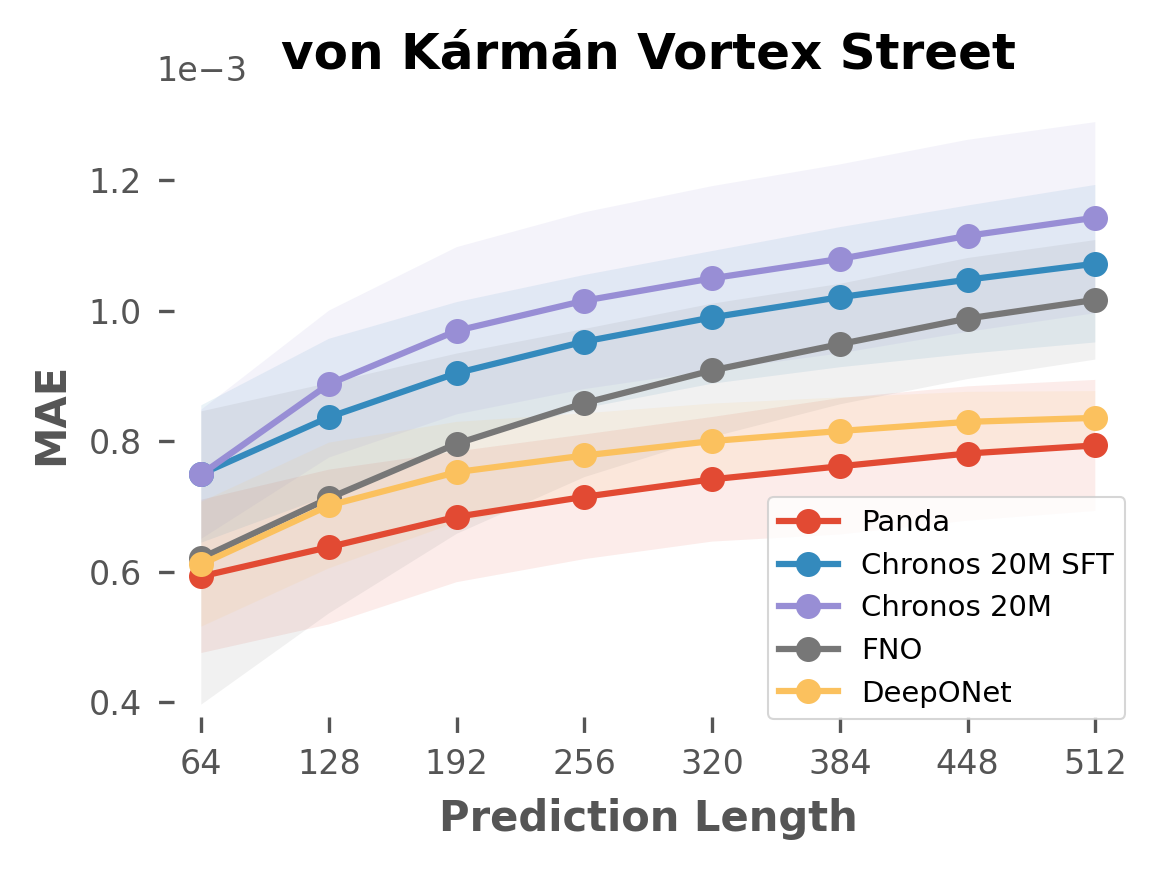

In [31]:
plt.figure(figsize=(4, 3))

model_names = ["Panda", "Chronos 20M SFT", "Chronos 20M", "FNO", "DeepONet"]
rollout_metrics = [
    our_model_rollout_metrics,
    chronos_ft_rollout_metrics,
    chronos_zs_rollout_metrics,
    fno_rollout_metrics,
    don_rollout_metrics,
]
for model, metrics in zip(model_names, rollout_metrics):
    means, medians, stds, stes = calculate_stats(metrics["mae"])
    plot_model_results(means, stds, "o", label=model)
    plt.xlabel("Prediction Length", fontweight="bold")
    plt.xticks(list(means.keys()))
    plt.title("von Kármán Vortex Street", fontweight="bold")
    plt.ylabel("MAE", fontweight="bold")
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

plt.legend(loc="lower right", frameon=True, fontsize=7)
plt.tight_layout()
plt.savefig(
    os.path.join(figs_save_dir, f"vonkarman_all_models_{metric_name}.pdf"),
    bbox_inches="tight",
)
plt.show()

In [32]:
metrics_combined = {
    "Panda": our_model_rollout_metrics,
    "Chronos 20M SFT": chronos_ft_rollout_metrics,
    "Chronos 20M": chronos_zs_rollout_metrics,
    "FNO": fno_rollout_metrics,
    "DeepONet": don_rollout_metrics,
}

In [33]:
import pickle

save_dir = "../outputs/vonkarman"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
with open(os.path.join(save_dir, "vonkarman_metrics_combined.pkl"), "wb") as f:
    pickle.dump(metrics_combined, f)